# Demonstration and Validation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning, get_probes, compute_scores
from tomo_challenge.classifiers.random_forest import RandomForest

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


## Load Datasets

Define the data to use:

In [6]:
bands='riz'
include_colors=True
include_errors=True

Load the Buzzard training data:

In [7]:
training_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(training_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(training_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Load the validation data:

In [8]:
validation_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/validation.hdf5'
valid_data = load_data(validation_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
valid_z = load_redshift(validation_file)
print(f'Loaded {len(valid_data)} validation rows.')

Loaded 10817982 validation rows.


## Random Forest Example

Initialize a random forest classifier with 4 bins:

In [9]:
nbins_rf = 4
classifier = RandomForest(bands, {'bins': nbins_rf})

Train on a fraction of the data:

In [10]:
ntrain_rf = 20000
classifier.train(train_data[:ntrain_rf], train_z[:ntrain_rf])

Finding bins for training data
Fitting classifier


Test on a fraction of the validation data:

In [11]:
nvalid_rf = 50000
idx_rf = classifier.apply(valid_data[:nvalid_rf])
z_rf = valid_z[:nvalid_rf]

Plot true redshift distributions of the random forest bin assignments:

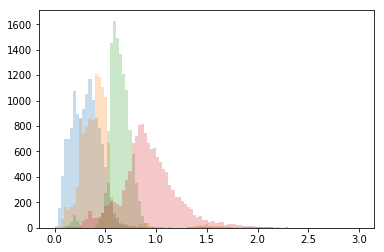

In [12]:
for bin in range(4):
    plt.hist(z_rf[idx_rf==bin], bins=np.linspace(0, 3, 100), alpha=0.25)

### Jax Cosmo Calculations

Demonstration of how to calculate the predicted angular cl's, noise and Gaussian covariance using jax-cosmo:

In [13]:
import jax_cosmo.angular_cl

In [14]:
cosmo = jax_cosmo.Cosmology(
    Omega_c = 0.27,
    Omega_b = 0.045,
    h = 0.67,
    n_s = 0.96,
    sigma8 = 0.840484495,
    Omega_k=0.,
    w0=-1.,
    wa=0.
)

In [15]:
ell, _ = ell_binning()

In [16]:
tomo_bin = jax.nn.one_hot(idx_rf, idx_rf.max() + 1)

In [17]:
probes = get_probes(tomo_bin, z_rf, binned_nz=True)

In [18]:
cl_jc = jax_cosmo.angular_cl.angular_cl(cosmo, ell, probes)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [19]:
nl_jc = jax_cosmo.angular_cl.noise_cl(ell, probes)

In [20]:
cov_jc = jax_cosmo.angular_cl.gaussian_cl_covariance(ell, probes, cl_jc, nl_jc, f_sky=0.25, sparse=True)

### Fast Reweighted Calculations

Demonstration of how to calculate the same quantities using fast reweighting. Note that the precomputed `init_data` already assumes a specific cosmology (matching the one above):

In [3]:
from zotbin.binned import *
import zotbin.reweight

Load initialization data to use for fast calculations:

In [5]:
init_data = load_binned('binned_80_4k.npz')

In [21]:
zedges, ell, ngals, noise, cl_in = init_data

Calculate the relative weights of each predefined redshift slice for each random forest label:

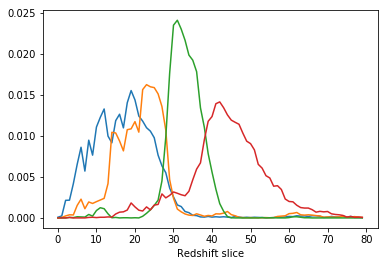

In [25]:
w = get_binned_weights(zedges, z_rf, idx_rf)
plt.plot(w.T)
plt.xlabel('Redshift slice');

Use identical labels for the number density and weak-lensing probes:

In [23]:
weights = jnp.array([w, w])

Calculate reweighted quantities and compare with the jax-cosmo quantities obtained above:

In [27]:
cl_rw = zotbin.reweight.reweight_cl(weights, ngals, cl_in)

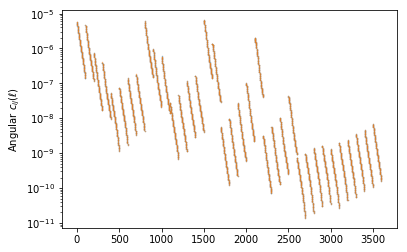

In [29]:
plt.semilogy(cl_jc.reshape(-1), '.', ms=1, alpha=0.5)
plt.semilogy(cl_rw[-1].reshape(-1), '.', ms=1, alpha=0.5)
plt.ylabel('Angular $c_{ij}(\ell)$');

In [30]:
nl_rw = zotbin.reweight.reweight_noise_cl(weights, ngals, noise, gals_per_arcmin2=20.)

In [31]:
assert np.allclose(nl_jc[:, 0], nl_rw[:, 0])

In [32]:
cov_rw = zotbin.reweight.gaussian_cl_covariance(ell, cl_rw[-1], nl_rw, f_sky=0.25, sparse=True)

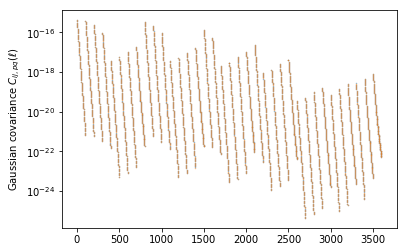

In [34]:
plt.semilogy(cov_jc[-1].reshape(-1), '.', ms=1, alpha=0.5)
plt.semilogy(cov_rw[-1].reshape(-1), '.', ms=1, alpha=0.5)
plt.ylabel('Gaussian covariance $C_{ij,pq}(\ell)$');

### Jax Cosmo Scores

Calculate scores using the jax_cosmo implementation provided with tomo_challenge. Note that they will vary slightly each time you retrain the random forest because it is random :-)

In [35]:
scores_rf = compute_scores(idx_rf, z_rf, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])
scores_rf

{'SNR_3x2': 1207.0001220703125,
 'FOM_3x2': 1449.198486328125,
 'FOM_DETF_3x2': 40.032005310058594}

Benchmark the jax-cosmo score calculation:

In [20]:
%timeit compute_scores(idx_rf, z_rf, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

59.8 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Fast Reweighted Scores

Calculate the fast reweighted scores. Results should be close to the ones above but will not be identical. The main expected differences are:
 - jax-cosmo uses 512 integration steps in $a$ to calculate each $c_\ell$ while the reweighted calculation uses 4096 (8x more).
 - the additional matrix calculations used for reweighting can introduce some round-off error.

In [36]:
scores = get_binned_scores(idx_rf, z_rf, *init_data)
scores

{'FOM_3x2': DeviceArray(1427.3241, dtype=float32),
 'FOM_DETF_3x2': DeviceArray(39.611397, dtype=float32),
 'SNR_3x2': DeviceArray(1208.6547, dtype=float32)}

Benchmark the reweighted calculation, which should take < 10ms with a GPU:

In [37]:
%timeit get_binned_scores(idx_rf, z_rf, *init_data)['FOM_DETF_3x2'].block_until_ready()

8.38 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
